# Test using cross-correlation to measure differential travel times of high-Q gliders between nearby stations

In [11]:
# Imports
from os.path import join
from matplotlib.pyplot import subplots
from matplotlib.ticker import MultipleLocator
from obspy.signal.cross_correlation import correlate
from pandas import Timestamp
from scipy.signal import correlate, hilbert
from numpy import linspace, geomspace
from numpy.linalg import norm

from utils_basic import GEO_COMPONENTS, ROOTDIR_GEO, SAMPLING_RATE_GEO
from utils_preproc import read_and_process_windowed_geo_waveforms
from utils_wavelet import get_stream_cwt
from utils_plot import component_to_title, get_geo_component_color, plot_3c_waveforms_and_cwts, save_figure

In [12]:
# Inputs
## Data
starttime = Timestamp("2020-01-13T19:36:12Z")
dur = 45.0 # seconds
station1 = "A01"
station2 = "A02"

normalize = False # Normalize the signals with the envelope or not

freqmin = 40.0
freqmax = 100.0

sampling_int = 1.0 / SAMPLING_RATE_GEO

## Wavelet transform
wavelet = "cmor"
bandwidth = 20.0
center_freq = 2.0
scales = geomspace(2, 100, 100)

## Plotting
ylim_wf = (-50.0, 50.0)
ylim_freq = (40.0, 120.0)

dbmin = 0.0
dbmax = 50.0

components = GEO_COMPONENTS

linewidth_wf = 0.2
linewidth_cc = 2

In [13]:
# Read the waveforms
stream = read_and_process_windowed_geo_waveforms(starttime, dur, stations=[station1, station2], freqmin=freqmin, freqmax=freqmax)

In [14]:
# Normalize the signals with the envelopes
if normalize:
    for trace in stream:
        signal = trace.data
        envelope = abs(hilbert(signal))
        trace.data = signal / envelope

In [15]:
# Compute the spectrograms using CWT
specs = get_stream_cwt(stream, wavelet=wavelet, bandwidth=bandwidth, center_freq=center_freq, scales=scales)

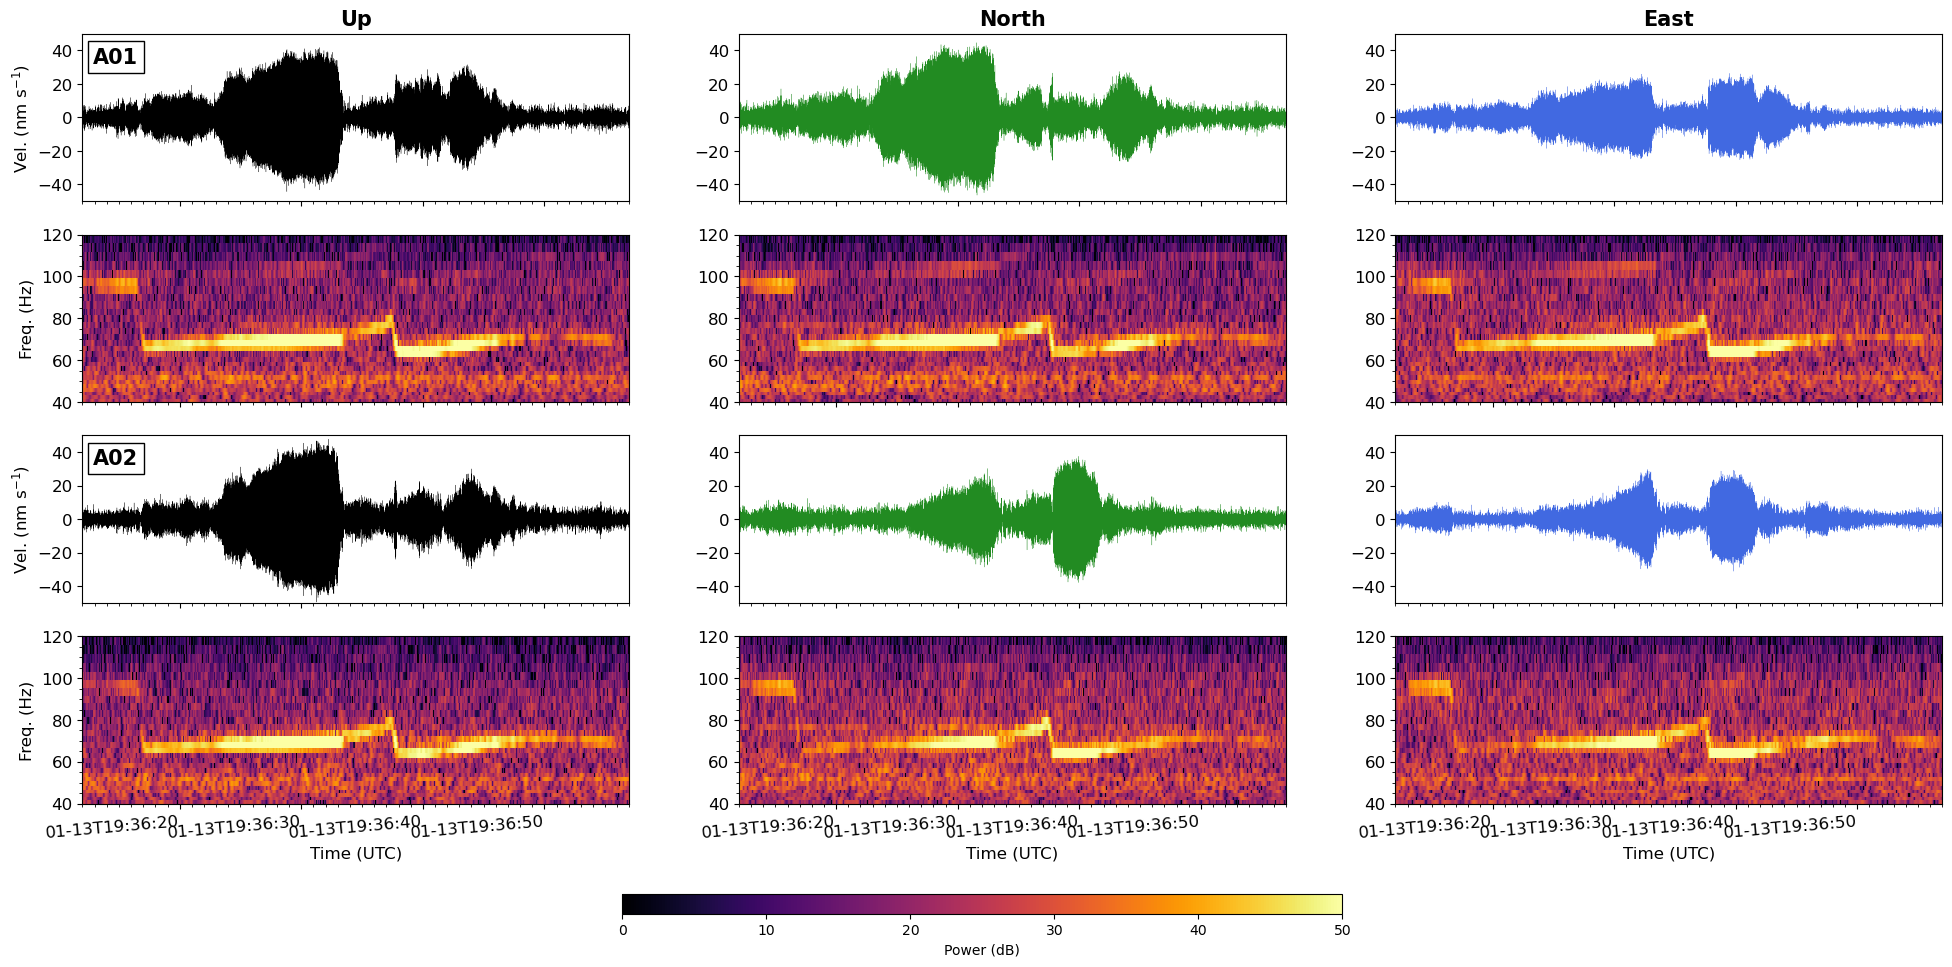

In [16]:
# Plot the waveforms and the spectrograms
fig_spec, axes = plot_3c_waveforms_and_cwts(stream, specs, ylim_wf=ylim_wf, ylim_freq=ylim_freq, 
                                       xdim_per_comp=8, ydim_per_sta=2.5, dbmin=dbmin, dbmax=dbmax, linewidth_wf=linewidth_wf,
                                       major_time_spacing=10.0, minor_time_spacing=1.0, major_freq_spacing=20.0, minor_freq_spacing=5.0)


In [17]:
# Save the figure
figname = f"waveforms_and_cwt_spec_{starttime.strftime('%Y%m%dT%H%M%S')}_dur{dur:.0f}s_{station1}_{station2}.png"
save_figure(fig_spec, figname, outdir=ROOTDIR_GEO)

Figure saved to /Volumes/OmanData/data/geophones/waveforms_and_cwt_spec_20200113T193612_dur45s_A01_A02.png


In [18]:
# Compute CC for the 3 components
ccdict = {}
for component in components:
    signal1 = stream.select(station=station1, component=component)[0].data
    signal2 = stream.select(station=station2, component=component)[0].data
    cc = correlate(signal1, signal2, mode="full") / norm(signal1) / norm(signal2)
    ccdict[component] = cc

Text(0.5, 1.1, 'A01-A02')

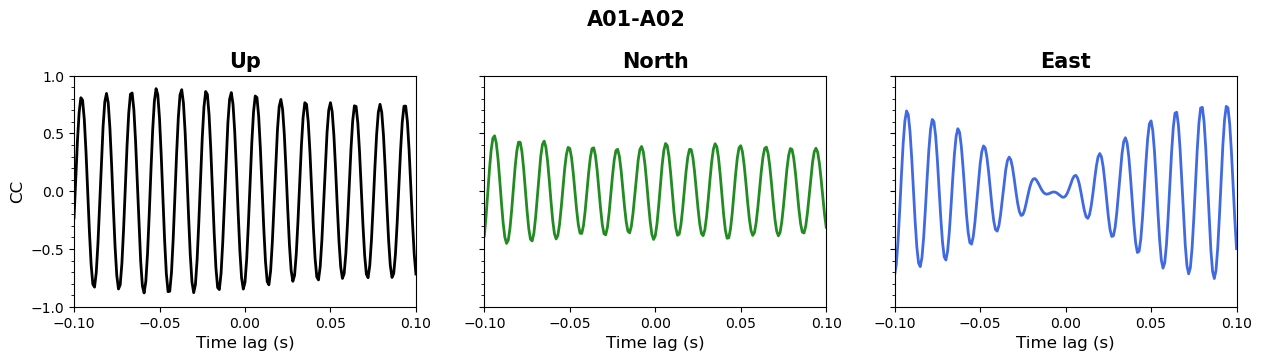

In [19]:
# Plot the CCs
fig_cc, axes = subplots(1, 3, figsize=(15, 3), sharey=True)
for i, component in enumerate(components):
    ax = axes[i]
    cc = ccdict[component]
    numpts = len(cc)

    mintime_cc = -(numpts - 1) / 2 * sampling_int
    maxtime_cc = (numpts - 1) / 2 * sampling_int
    timeax_cc = linspace(mintime_cc, maxtime_cc, numpts)

    color = get_geo_component_color(component)
    ax.plot(timeax_cc, cc, color=color, linewidth=linewidth_cc)

    ax.set_xlim(-0.1, 0.1)
    ax.set_ylim(-1, 1)

    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))

    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    
    ax.set_xlabel("Time lag (s)", fontsize=12)

    if i == 0:
        ax.set_ylabel("CC", fontsize=12)

    title = component_to_title(component)
    ax.set_title(title, fontsize=15, fontweight="bold")

fig_cc.suptitle(f"{station1}-{station2}", fontsize=15, fontweight="bold", y=1.1)

In [20]:
figname = f"cc_{starttime.strftime('%Y%m%dT%H%M%S')}_dur{dur:.0f}s_{station1}_{station2}.png"
save_figure(fig_cc, figname, outdir=ROOTDIR_GEO)

Figure saved to /Volumes/OmanData/data/geophones/cc_20200113T193612_dur45s_A01_A02.png
